<a href="https://colab.research.google.com/github/GitKritiM/Stock_Price_Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [13]:
# GRU Model for Stock Price Prediction
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [14]:
def prepare_data(stock_data, lookback=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [15]:
def build_gru_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [16]:
def predict_future_prices(model, stock_data, scaler, future_days=30):
    lookback = 60  # Same as in prepare_data
    last_sequence = stock_data['Close'].values[-lookback:]
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))

    future_predictions = []
    for _ in range(future_days):
        # Predict the next day's price
        next_day_scaled = model.predict(last_sequence_scaled[-lookback:].reshape(1, lookback, 1))
        future_predictions.append(next_day_scaled[0][0])
        # Update the sequence with the predicted value
        last_sequence_scaled = np.append(last_sequence_scaled, next_day_scaled)

    # Inverse transform the predictions to get actual prices
    future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_prices

In [17]:
import matplotlib.pyplot as plt

def predict_stock_price(ticker, start_date, end_date, future_days=0, test_split=0.2):
    stock_data = get_stock_data(ticker, start_date, end_date)
    X, y, scaler = prepare_data(stock_data)

    # Split into train and test
    split_index = int(len(X) * (1 - test_split))
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    model = build_gru_model((X.shape[1], 1))
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)

    print(f"\n📊 Model Evaluation on Test Set:")
    print(f"🔹 MSE  = {mse:.4f}")
    print(f"🔹 RMSE = {rmse:.4f}")
    print(f"🔹 MAE  = {mae:.4f}")

    # 📈 Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label='Actual Price', color='green')
    plt.plot(y_pred_actual, label='Predicted Price', color='orange')
    plt.title(f"{ticker} - Actual vs Predicted Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if future_days > 0:
        future_prices = predict_future_prices(model, stock_data, scaler, future_days)
        return future_prices
    else:
        last_sequence = X[-1].reshape(1, X.shape[1], 1)
        predicted_scaled = model.predict(last_sequence)
        predicted_price = scaler.inverse_transform(predicted_scaled)
        return predicted_price[0][0]


In [18]:
# GPT-2 for Chatbot Responses
def generate_commentary(predicted_price):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2")

    input_text = f"Stock price is predicted to be {predicted_price:.2f}. The market outlook is"
    inputs = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


In [19]:
# Unified Pipeline
def unified_pipeline(ticker, start_date, end_date, future_days=0):
    # Predict stock price
    if future_days > 0:
        future_prices = predict_stock_price(ticker, start_date, end_date, future_days)
        print(f"Predicted future stock prices for {ticker} for the next {future_days} days:")
        for i, price in enumerate(future_prices, 1):
            print(f"Day {i}: ${price[0]:.2f}")
        # Generate commentary for the last predicted price
        commentary = generate_commentary(future_prices[-1][0])
    else:
        predicted_price = predict_stock_price(ticker, start_date, end_date)
        print(f"Predicted stock price for {ticker} is ${predicted_price:.2f}")
        # Generate commentary for the predicted price
        commentary = generate_commentary(predicted_price)

    print("Market Commentary:", commentary)

In [20]:
# Chatbot Integration
def chat_with_rag():
    print("Welcome to the GenAI Financial Chatbot. Type 'exit' to end the conversation.")
    while True:
        query = input("You: ")
        if query.lower() in ["exit", "quit"]:
            break
        elif "predict stock price" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            try:
                unified_pipeline(ticker, start_date, end_date)
            except Exception as e:
                print(f"Chatbot: Error predicting stock price. {e}")
        elif "predict future stock price" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            future_days = int(input("Enter the number of days to predict: "))
            try:
                unified_pipeline(ticker, start_date, end_date, future_days)
            except Exception as e:
                print(f"Chatbot: Error predicting future stock prices. {e}")
        elif "show past stock prices" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            try:
                stock_data = get_stock_data(ticker, start_date, end_date)
                print(f"Chatbot: Past stock prices for {ticker} from {start_date} to {end_date}:")
                print(stock_data[['Date', 'Close']])
            except Exception as e:
                print(f"Chatbot: Error fetching past stock prices. {e}")
        else:
            try:
                response = generate_commentary("General query: " + query)
                print(f"Chatbot: {response}")
            except Exception as e:
                print(f"Chatbot: Error generating response. {e}")

Welcome to the GenAI Financial Chatbot. Type 'exit' to end the conversation.
You: predict stock price
Enter the stock ticker: AAPL
Enter the start date (YYYY-MM-DD): 2023-01-01
Enter the end date (YYYY-MM-DD): 2025-01-01


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.1076
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0146
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0079
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0084
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0053
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0045
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0043
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0045
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0037
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0035
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step

📊 Model Evaluation on Test Set:
🔹 MSE  = 37.8591
🔹 RMSE = 6.1530
🔹 MAE  = 5.2244


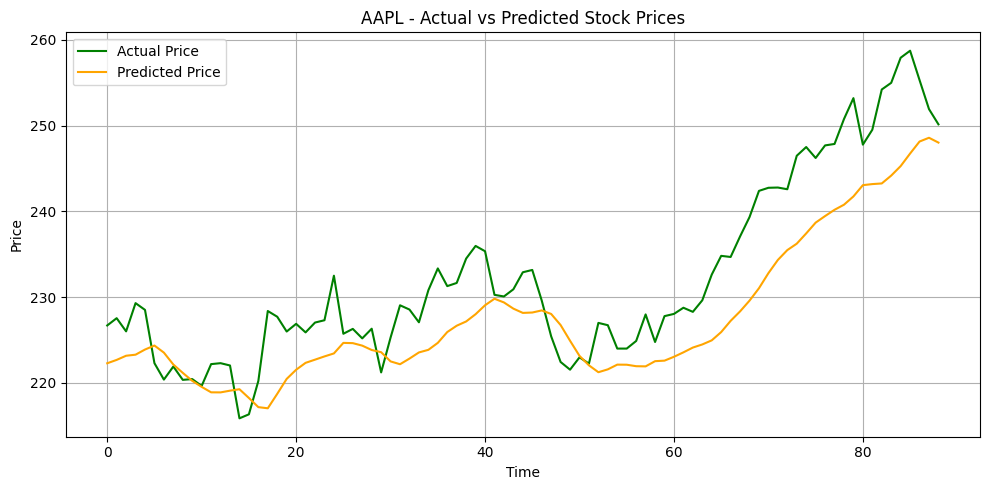

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted stock price for AAPL is $248.02


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Market Commentary: Stock price is predicted to be 248.02. The market outlook is for a price of 248.02.

The price of the stock is expected to be higher than the market price of the stock.

The price of the stock is expected to be higher than the market price of the stock.

The price of the stock is expected to be higher than the market price of the stock.

The price of the stock is expected to be higher than the market price of the


In [ ]:
# Run the chat
chat_with_rag()